In [7]:
import json
from IPython import embed
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import os
import argparse
import random
import time
#from torch.utils.tensorboard import SummaryWriter
import shutil

In [8]:
parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('--root-dir',
                    help='root dir to store all experiments', default='bc_results')
parser.add_argument('--exp-dir',
                    help='experiment directory', required=True)
parser.add_argument('--data', metavar='DIR',
                    help='path to dataset', default='bc_data')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=50, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                    'batch size of all GPUs on the current node when '
                    'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=0.01, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--reg-loss-weight', default=1.0, type=float,
                    help='weight for regression loss for arm action')
parser.add_argument('--cls-loss-weight', default=1.0, type=float,
                    help='weight for classification loss for gripper action')
parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')

#best_f1 = 0

_StoreAction(option_strings=['--gpu'], dest='gpu', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, help='GPU id to use.', metavar=None)

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix="", writer=None):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix
        self.writer = writer

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def log_tensorboard(self, epoch):
        if self.writer is not None:
            for meter in self.meters:
                self.writer.add_scalar(meter.name, meter.avg, epoch)

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def get_cls_metrics(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        accu = pred.eq(target)
        target_true = torch.sum(target).float()
        pred_true = torch.sum(pred).float()
        correct_true = torch.sum(accu * pred.byte()).float()
        precision = correct_true / pred_true
        recall = correct_true / target_true
        f1_score = (2 * precision * recall) / (precision + recall)
        accu = accu.float().mean()
        return accu, precision, recall, f1_score


In [10]:
class BCDataset(Dataset):

    def __init__(self, root_dir, dataset_type, input_mean=None, input_std=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset_type = dataset_type
#         with open('{}/{}.json'.format(root_dir, dataset_type), 'r') as f:
#             self.data = json.load(f)
#             for key in self.data:
#                 if key == 'gripper_action':
#                     self.data[key] = np.array(self.data[key]).astype(np.int64)
#                 else:
#                     self.data[key] = np.array(
#                         self.data[key]).astype(np.float32)
    
        self.data = {}
        self.data['observation'] = []
        self.data['arm_action'] = []

        
        for fn in os.listdir(root_dir):
            if fn.endswith('hdf5'):
                print(fn)
                hf = h5py.File(fn, 'r')
                
                if hf['goal_status']['satisfied'].shape[0] == 0:
                    print(fn, 'not successful')
                    continue
                if hf['goal_status']['satisfied'][-1,0] == 0:
                    print(fn, 'not successful')
                    continue
                
                reset1 = np.max(np.where(hf['agent_actions']['vr_robot'][:,27]))
                reset2 = np.max(np.where(hf['agent_actions']['vr_robot'][:,19]))
                reset = (max(reset1, reset2))
                
                

                left_hand_local = hf['agent_actions']['left_hand_local']
                right_hand_local = hf['agent_actions']['right_hand_local']
                left_hand_trigger_fraction = hf['agent_actions']['left_hand_trigger_fraction']
                right_hand_trigger_fraction = hf['agent_actions']['right_hand_trigger_fraction']


                print(left_hand_local.shape, left_hand_trigger_fraction.shape)
                proprioception = np.concatenate([left_hand_local, 
                                                 right_hand_local,
                                                 left_hand_trigger_fraction, 
                                                 right_hand_trigger_fraction],
                                               axis=1
                                               )


                keys = ['1', '62', '8', '98']

                task_obs = []
                for key in keys:
                    task_obs.append(hf['physics_data'][key]['position'])
                    task_obs.append(hf['physics_data'][key]['orientation'])

                task_obs = np.concatenate(task_obs, axis=1)

                observation = np.concatenate([proprioception, task_obs], axis=1)

                action = hf['agent_actions']['vr_robot']
                
                self.data['observation'].append(observation[reset:])
                self.data['arm_action'].append(action[reset:])
                

        self.data['observation'] = np.concatenate(self.data['observation'], axis=0)
        self.data['arm_action'] = np.concatenate(self.data['arm_action'], axis=0)
        
        train_size = int(self.data['observation'].shape[0] * 0.8)
        
        if self.dataset_type == 'train':
            self.data['observation'] = self.data['observation'][:train_size]
            self.data['arm_action'] = self.data['arm_action'][:train_size]
        else:
            self.data['observation'] = self.data['observation'][train_size:]
            self.data['arm_action'] = self.data['arm_action'][train_size:]
        

        #print(self.data)
            
        if dataset_type == 'train':
            input_mean = np.mean(self.data['observation'], axis=0)
            input_std = np.std(self.data['observation'], axis=0)
        self.input_mean = input_mean
        self.input_std = input_std

    def __len__(self):
        return len(self.data['observation'])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        observation = self.data['observation'][idx]
        arm_action = self.data['arm_action'][idx]
        observation = (observation - self.input_mean) / (self.input_std + 1e-10)

        
        observation = observation.astype(np.float32)
        arm_action = arm_action.astype(np.float32)
        arm_action = np.concatenate((arm_action[12:18], arm_action[20:26]))
        return observation, arm_action

d = BCDataset(root_dir='.', dataset_type='train')
print(len(d))
plt.plot(d.input_mean)
plt.plot(d.input_std)

lifting_cauldron_0_Rs_int_2021-08-30_01-10-08_replay.hdf5


NameError: name 'h5py' is not defined

In [11]:
import h5py
import matplotlib.pyplot as plt

hf = h5py.File('lifting_cauldron_0_Rs_int_2021-08-30_01-09-21_replay.hdf5', 'r')

left_hand_local = hf['agent_actions']['left_hand_local']
right_hand_local = hf['agent_actions']['right_hand_local']
left_hand_trigger_fraction = hf['agent_actions']['left_hand_trigger_fraction']
right_hand_trigger_fraction = hf['agent_actions']['right_hand_trigger_fraction']


print(left_hand_local.shape, left_hand_trigger_fraction.shape)
proprioception = np.concatenate([left_hand_local, 
                                 right_hand_local,
                                 left_hand_trigger_fraction, 
                                 right_hand_trigger_fraction],
                               axis=1
                               )


keys = ['1', '62', '8', '98']

task_obs = []
for key in keys:
    task_obs.append(hf['physics_data'][key]['position'])
    task_obs.append(hf['physics_data'][key]['orientation'])
    
task_obs = np.concatenate(task_obs, axis=1)

observation = np.concatenate([proprioception, task_obs], axis=1)

action = hf['agent_actions']['vr_robot']

#hf['physics_data'].keys()

(600, 7) (600, 1)


In [12]:
hf.keys()

<KeysViewHDF5 ['agent_actions', 'frame_data', 'goal_status', 'physics_data']>

In [13]:

class Model(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers,
                 arm_action_size):
        super(Model, self).__init__()
        assert num_layers > 0
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for i in range(1, num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
        self.arm_action_head = nn.Linear(hidden_size, arm_action_size)

    def forward(self, x):
        x = self.layers(x)
        arm_action = self.arm_action_head(x)
        return arm_action


def save_checkpoint(state, ckpt_dir, filename, is_best):
    torch.save(state, os.path.join(ckpt_dir, filename))
    if is_best:
        shutil.copyfile(os.path.join(ckpt_dir, filename),
                       os.path.join(ckpt_dir, 'model_best.pth.tar'))



In [14]:
def main():
    #global best_f1

    args = parser.parse_args(['--exp-dir', '.', '--data', '.'])
    root_dir = args.root_dir
    exp_dir = os.path.join(root_dir, args.exp_dir)
    ckpt_dir = os.path.join(exp_dir, 'ckpt')
    summary_dir = os.path.join(exp_dir, 'summary')
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(summary_dir, exist_ok=True)

    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True

    model = Model(input_size=44,
                  hidden_size=64,
                  num_layers=5,
                  arm_action_size=12,
                  )

    if args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model.cuda(args.gpu)
    else:
        model = torch.nn.DataParallel(model).cuda()

    reg_criterion = nn.MSELoss().cuda(args.gpu)
    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    
    cls_criterion = None
    writer = None
#     if args.resume:
#         if os.path.isfile(args.resume):
#             print("=> loading checkpoint '{}'".format(args.resume))
#             if args.gpu is None:
#                 checkpoint = torch.load(args.resume)
#             else:
#                 # Map model to be loaded to specified single gpu.
#                 loc = 'cuda:{}'.format(args.gpu)
#                 checkpoint = torch.load(args.resume, map_location=loc)
#             args.start_epoch = checkpoint['epoch']
#             #best_f1 = checkpoint['best_f1']
#             if args.gpu is not None:
#                 # best_acc1 may be from a checkpoint from a different GPU
#             #    best_f1 = best_f1.to(args.gpu)
#             model.load_state_dict(checkpoint['state_dict'])
#             optimizer.load_state_dict(checkpoint['optimizer'])
#             print("=> loaded checkpoint '{}' (epoch {})"
#                   .format(args.resume, checkpoint['epoch']))
#         else:
#             print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True

    train_dataset = BCDataset(args.data, 'train')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

    val_dataset = BCDataset(
        args.data, 'val', train_dataset.input_mean, train_dataset.input_std)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

#     if args.evaluate:
#         validate(val_loader, model, reg_criterion, cls_criterion, -1, args)
#         return

    #writer = SummaryWriter(summary_dir)
    best_l1 = np.inf
    
    l1s = []
    for epoch in range(args.start_epoch, args.epochs):
        # train for one epoch
        train(train_loader, model, reg_criterion,
              cls_criterion, optimizer, epoch, args, writer)

        #evaluate on validation set
        l1 = validate(val_loader, model, reg_criterion, cls_criterion, epoch, args, writer)
        l1s.append(l1)
        is_best = l1 < best_l1
        best_l1 = min(l1, best_l1)

        save_checkpoint(
        {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'input_mean': train_dataset.input_mean,
            'input_std': train_dataset.input_std
        },
        ckpt_dir=ckpt_dir,
        filename='checkpoint_{}.pth.tar'.format(epoch),
        is_best=is_best,
        )
    plt.plot(l1s)

def train(train_loader, model, reg_criterion, cls_criterion, optimizer, epoch, args, writer):
    batch_time = AverageMeter('Train Time', ':6.3f')
    data_time = AverageMeter('Train Data', ':6.3f')
    reg_losses = AverageMeter('Train Regression Loss', ':.4e')
    cls_losses = AverageMeter('Train Classification Loss', ':.4e')
    total_losses = AverageMeter('Train Total Loss', ':.4e')
    accuracy = AverageMeter('Train Accuracy', ':6.2f')
    precision = AverageMeter('Train Precision', ':6.2f')
    recall = AverageMeter('Train Recall', ':6.2f')
    f1_score = AverageMeter('Train F1 Score', ':6.2f')

#     progress = ProgressMeter(
#         len(train_loader),
#         [batch_time, data_time, reg_losses, cls_losses,
#             accuracy, precision, recall, f1_score],
#         prefix="Train Epoch: [{}]".format(epoch),
#         writer=writer)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (obj_pos, arm_action) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        obj_pos = obj_pos.cuda(args.gpu, non_blocking=True)
        arm_action = arm_action.cuda(args.gpu, non_blocking=True)
#         gripper_action = gripper_action.cuda(args.gpu, non_blocking=True)

        # compute output
        arm_action_pred = model(obj_pos)
        reg_loss = reg_criterion(arm_action_pred, arm_action)
#         cls_loss = cls_criterion(gripper_action_pred, gripper_action)
#         loss = args.reg_loss_weight * reg_loss + args.cls_loss_weight * cls_loss
        loss = reg_loss
        print(epoch, loss)
        # measure accuracy and record loss
#         accu, prec, recl, f1 = get_cls_metrics(
#             gripper_action_pred, gripper_action)
#         reg_losses.update(reg_loss.item(), obj_pos.size(0))
#         cls_losses.update(cls_loss.item(), obj_pos.size(0))
#         total_losses.update(loss.item(), obj_pos.size(0))
#         accuracy.update(accu.item(), obj_pos.size(0))
#         precision.update(prec.item(), obj_pos.size(0))
#         recall.update(recl.item(), obj_pos.size(0))
#         f1_score.update(f1.item(), obj_pos.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if i % args.print_freq == 0:
#             progress.display(i)

#     progress.log_tensorboard(epoch)


def validate(val_loader, model, reg_criterion, cls_criterion, epoch, args, writer=None):
#     batch_time = AverageMeter('Val Time', ':6.3f')
#     data_time = AverageMeter('Val Data', ':6.3f')
#     reg_losses = AverageMeter('Val Regression Loss', ':.4e')
#     cls_losses = AverageMeter('Val Classification Loss', ':.4e')
#     total_losses = AverageMeter('Val Total Loss', ':.4e')
#     accuracy = AverageMeter('Val Accuracy', ':6.2f')
#     precision = AverageMeter('Val Precision', ':6.2f')
#     recall = AverageMeter('Val Recall', ':6.2f')
#     f1_score = AverageMeter('Val F1 Score', ':6.2f')

#     progress = ProgressMeter(
#         len(val_loader),
#         [batch_time, data_time, reg_losses, cls_losses,
#             accuracy, precision, recall, f1_score],
#         prefix="Val Epoch: [{}]".format(epoch),
#         writer=writer)

    # switch to evaluate mode
    model.eval()

    reg_losses = []
    
    with torch.no_grad():
        end = time.time()
        for i, (obj_pos, arm_action) in enumerate(val_loader):
            obj_pos = obj_pos.cuda(args.gpu, non_blocking=True)
            arm_action = arm_action.cuda(args.gpu, non_blocking=True)
            #gripper_action = gripper_action.cuda(
            #    args.gpu, non_blocking=True)

            # compute output
            arm_action_pred = model(obj_pos)
            reg_loss = reg_criterion(arm_action_pred, arm_action)
            #cls_loss = cls_criterion(gripper_action_pred, gripper_action)
            loss = reg_loss#args.reg_loss_weight * reg_loss + args.cls_loss_weight * cls_loss
            reg_losses.append(loss.cpu().item())
            # measure accuracy and record loss
            #accu, prec, recl, f1 = get_cls_metrics(
            #    gripper_action_pred, gripper_action)
            #reg_losses.update(reg_loss.item(), obj_pos.size(0))
            #cls_losses.update(cls_loss.item(), obj_pos.size(0))
            #total_losses.update(loss.item(), obj_pos.size(0))
            #accuracy.update(accu.item(), obj_pos.size(0))
            #precision.update(prec.item(), obj_pos.size(0))
            #recall.update(recl.item(), obj_pos.size(0))
            #f1_score.update(f1.item(), obj_pos.size(0))

            # measure elapsed time
            #batch_time.update(time.time() - end)
            #end = time.time()

            #if i % args.print_freq == 0:
            #    progress.display(i)

    #progress.log_tensorboard(epoch)
    #return f1_score.avg
    return np.mean(reg_losses)


/home/fei/miniconda2/envs/igibson/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


lifting_cauldron_0_Rs_int_2021-08-30_01-10-08_replay.hdf5
(600, 7) (600, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-23-41_replay.hdf5
(400, 7) (400, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-18-26_replay.hdf5
(400, 7) (400, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-26-00_replay.hdf5
(400, 7) (400, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-12-27_replay.hdf5
lifting_cauldron_0_Rs_int_2021-08-30_01-12-27_replay.hdf5 not successful
lifting_cauldron_0_Rs_int_2021-08-30_01-28-53_replay.hdf5
(400, 7) (400, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-19-10_replay.hdf5
(400, 7) (400, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-22-44_replay.hdf5
(600, 7) (600, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-06-46_replay.hdf5
(400, 7) (400, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-15-13_replay.hdf5
(600, 7) (600, 1)
lifting_cauldron_0_Rs_int_2021-08-30_01-19-53_replay.hdf5
lifting_cauldron_0_Rs_int_2021-08-30_01-19-53_replay.hdf5 not successful
lifting_cauldron_0_Rs_int_2021-08-30_01-11-41_replay.h

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


1 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


2 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


5 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0001, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


8 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0002, device=

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
12 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


13 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


14 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


15 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


16 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
16 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
17 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
18 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
18 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
19 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
19 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


20 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
20 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
21 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
21 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
22 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
23 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
24 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
24 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
25 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
25 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
26 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
26 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
27 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


28 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(9.3098e-05, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(9.5662e-05, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
28 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(8.8300e-05, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
29 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(9.1838e-05, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


30 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
31 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


32 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(9.6446e-05, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


32 tensor(9.8738e-05, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
32 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
33 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
34 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
34 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
35 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
35 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
36 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


37 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(9.8693e-05, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
37 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
37 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
38 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(9.9580e-05, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(8.4515e-05, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
39 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
40 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


41 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(9.5005e-05, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
41 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
41 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


42 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
42 tensor(9.7517e-05, device='cuda:0', grad_fn=<MseLossBackward>)
42 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
43 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
43 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
44 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
44 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(9.9627e-05, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
45 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
45 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
46 tenso

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(9.3387e-05, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
47 tensor(9.2766e-05, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(9.9375e-05, device='cuda:0', grad_fn=<MseLossBackward>)
48 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
48 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


49 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(9.8893e-05, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
49 t

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


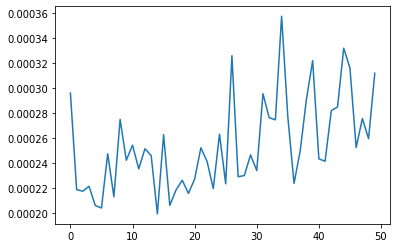

In [15]:
main()